In [4]:
## Import required Python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy, scipy.stats
import io
import base64
#from IPython.core.display import display
from IPython.display import display, HTML, Image
from urllib.request import urlopen

try:
    import astropy as apy
    import astropy.table
    _apy = True
    #print('Loaded astropy')
except:
    _apy = False
    #print('Could not load astropy')

## Customising the font size of figures
plt.rcParams.update({'font.size': 14})

## Customising the look of the notebook
display(HTML("<style>.container { width:95% !important; }</style>"))
## This custom file is adapted from https://github.com/lmarti/jupyter_custom/blob/master/custom.include
HTML('custom.css')
#HTML(urlopen('https://raw.githubusercontent.com/bretonr/intro_data_science/master/custom.css').read().decode('utf-8'))

In [2]:
## Custom imports
from scipy.stats import binom, poisson, chi2, norm, uniform
from scipy.optimize import curve_fit
from math import ceil, pi
from numpy import exp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle
from matplotlib.colors import makeMappingArray
import pandas as pd
from tqdm import trange

In [3]:
## Adding a button to hide the Python source code
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>''')

<div class="container-fluid">
    <div class="row">
        <div class="col-md-8" align="center">
            <h1>PHYS 10791: Introduction to Data Science</h1>
            <!--<h3>2019-2020 Academic Year</h3><br>-->
        </div>
        <div class="col-md-3">
            <img align='center' style="border-width:0" src="images/UoM_logo.png"/>
        </div>
    </div>
</div>

<div class="container-fluid">
    <div class="row">
        <div class="col-md-2" align="right">
            <b>Course instructors:&nbsp;&nbsp;</b>
        </div>
        <div class="col-md-9" align="left">
            <a href="http://www.renebreton.org">Prof. Rene Breton</a> - Twitter <a href="https://twitter.com/BretonRene">@BretonRene</a><br>
            <a href="http://www.hep.manchester.ac.uk/u/gersabec">Dr. Marco Gersabeck</a> - Twitter <a href="https://twitter.com/MarcoGersabeck">@MarcoGersabeck</a>
        </div>
    </div>
</div>

# Chapter 11

## Syllabus

1. Probabilities and interpretations
2. Probability distributions
3. Parameter estimation
4. Maximum likelihood + extended maximum likelihood
5. Least square, chi2, correlations
6. Monte Carlo basics
7. Probability 
8. Hypothesis testing
9. Confidence level
10. Goodness of fit tests
11. **Limit setting**
12. Introduction to multivariate analysis techniques

## Topics

**[11 Limit setting](#11-Limit-setting)**

**[11.1 Coverage](#11.1-Coverage)**

**[11.2 The issue of flip-flopping](#11.2-The-issue-of-flip-flopping)**

**[11.3 The Feldman-Cousins method](#11.3-The-Feldman-Cousins-method)**

**[11.4 The CLs method](#11.4-The-CLs-method)**



## 11 Limit setting

We discussed confidence leves in Chapters 8 and 9. These were mostly discussed in scenarios not affected by limitations of the parameters that are being assessed. In this part we cover the somewhat more complicated situation when physical boundaries apply, e.g. that a quantity has to be positive (e.g. a mass).

This Chapter largely (11.1-11.3) follows a paper by Feldman and Cousins: <a href="https://journals.aps.org/prd/abstract/10.1103/PhysRevD.57.3873">Phys. Rev. D57 (1998) 3873</a>. This is an excellent paper well worth a read also at your level.

Below is a hypothetical confidence belt based on Gaussian probability density functions with varying mean and width. In this example the parameters are

mean $ = 2 + 3 \times \sqrt{\mu}$,

and

width $ = 0.5 + 0.05 \times \mu$.

As we are now dealing with a continuous variable, the confidence level covered by each horizontal band is exactly 90%.

A problem arises if we want to assign a confidence interval for $\mu$ for a measured value around $x=1$.

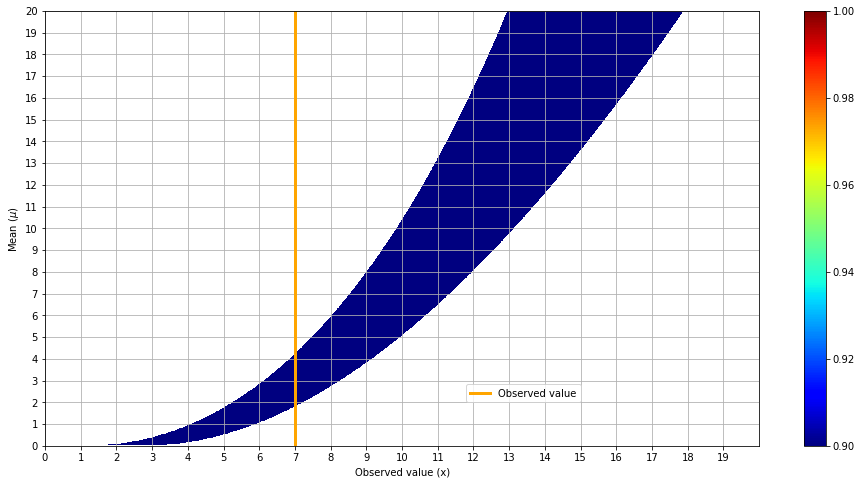

In [3]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp, norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 20.
max_x = 20
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm, xp, p = get_central_interval(cl, 2. + 3. * pow( mean, 0.5 ), 0.5 + mean / max_mean) # use funny function for mean and linearly increasing sigma
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')


ax.plot([7.]*2,[0,max_mean], label='Observed value', color='orange', linewidth=3)
ax.legend(loc=[0.59,0.10])

plt.colorbar(norms)
plt.show()


### 11.1 Coverage

The construction of confidence belts, which we discussed previously, is based on defining horizontal intervals according to a certain confidence level $C$. These can be constructed as central confidence intervals according to

$$P(x<x_1|\mu)=P(x>x_2|\mu)=(1-C)/2,$$

or as upper confidence limit intervals

$$P(x<x_1|\mu)=1-C.$$

For a given measured value of $x_0$, these then lead to an interval for $\mu$ with

$$P(\mu\in[\mu_1,\mu_2])=C.$$

This statement means that the unknown true value of $\mu$, $\mu_t$ lies within the interval $[\mu_1,\mu_2]$ in a fraction $C$ of the experiments conducted.

This has to be distinguished from the statement that the degree of belief that $\mu_t$ lies in $[\mu_1,\mu_2]$ is $C$. This is a Bayesian statement for $P(\mu_t|x_0)$ for which we need to know the prior for $\mu_t$ according to Bayes' theorem

$$P(\mu_t|x_0)=P(x_0|\mu_t)P(\mu_t)/P(x_0).$$

Returning to the previous equation, this being satisfied indicates that the intervals _cover_ $\mu$ at the stated confidence, or that they have the correct _coverage_.

Alternatively, the case when

$$P(\mu\in[\mu_1,\mu_2])<C,$$

is called _undercoverage_. This is a serious issue as this implies the existence of more information than is the case in reality.

Conversely,

$$P(\mu\in[\mu_1,\mu_2])>C,$$

is called _overcoverage_ , which is in most cases a less severe issue, but it leads to a loss of rejection power against false hypotheses. This case is sometimes called conservatism. Being conservative is never optimal and one should always strive to make estimates as accurate as possible.

#### Recap: Confidence levels from Gaussians

In the case of Gaussian distribution functions, the construction becomes very simple. The $x_-$ and $x_+$ curves become straight lines and the limits are obtained simply by $\mu_\pm=x_0\pm n\sigma$, where $n=1$ for 68% confidence level, $n=1.64$ for 90% confidence level, and so on.

This is a simplified case of the introductory example above.

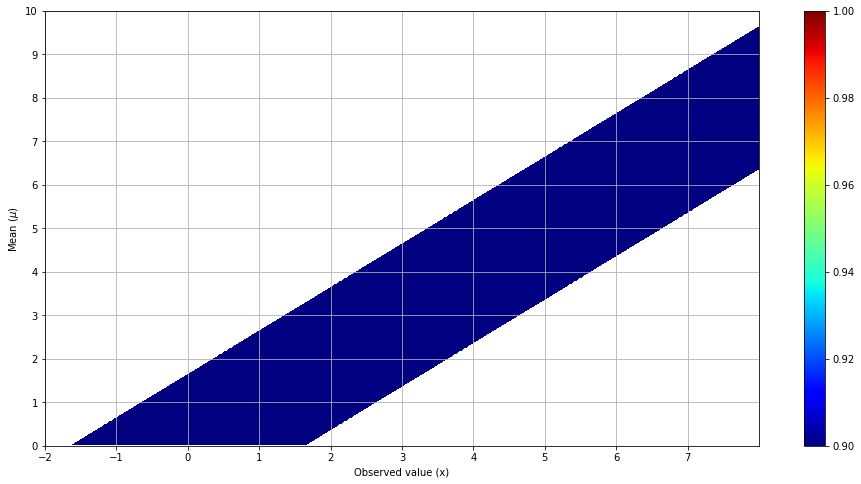

In [4]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp, norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 10.
min_x = -2.
max_x = 8.
sigma = 1.
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm, xp, p = get_central_interval(cl, mean, sigma) # use funny function for mean and linearly increasing sigma
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(min_x,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/10. for x in range(11)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x))])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')

plt.colorbar(norms)
plt.show()


#### Recap: Measurement of a constrained quantity

The measurement of a mass was mentioned in the introduction to confidence levels. 

Assuming this measurement occurs with Gaussian uncertainties, we have the probability distribution function

$$P(x|\mu)=\frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu)^2/2\sigma^2}.$$

The construction with a confidence belt fails miserably when a negative mass is measured with a relatively small uncertainty, e.g. $(-0.5\pm0.2)~$g. When trying to construct a 90% confidence interval, we would get $\mu_\pm=(-0.5\pm0.2\times 1.64)~$g, i.e. even $\mu_+=-0.172~$g remains negative.

A solution to this issue is a Bayesian construction with a normalisation that takes the physical limit into account. For example for positive masses, one gets

$$P(\mu|x)=\frac{e^{-(x-\mu)^2/2\sigma^2}}{\int_0^\infty e^{-(x-\mu')^2/2\sigma^2}d\mu'}(x<0).$$

This construction will then lead to one limit being zero, i.e. we set an upper limit. 

We will now discuss the limitations of this approach.

#### Limitations of central confidence belts

Let us continue to consider the example of a Gaussian probability density function.

If we decide _a priori_ to construct central intervals, we get the confidence belt already shown a couple of slides ago.

This belt achieves correct coverage for all allowed values of $\mu$. However, as the measured value $x_0$ gets more and more negative the corresponding interval $\mu_\pm$ tends towards the empty set, which is reached for $x_0\le-1.64\sigma$.

This is clearly an unsatisfactory result. One alternative might be to continue the confidence belt to negative values of $\mu$, but this is similarly unsatisfactory as obtaining a set $\mu_\pm$ with a negative $\mu_-$ does not really make sense as we would know that any negative values of $\mu$ are unphysical.

Furthermore, the probability distribution function $P(x|\mu)$ may be ill-defined for negative $\mu$.

#### Limitations of upper confidence intervals

We can similarly to the previous case set out _a priori_ to construct upper limit intervals.

In this case the same problem arises for negative measured values with the continuation to negative values of $\mu$ being equally unsatisfactory.

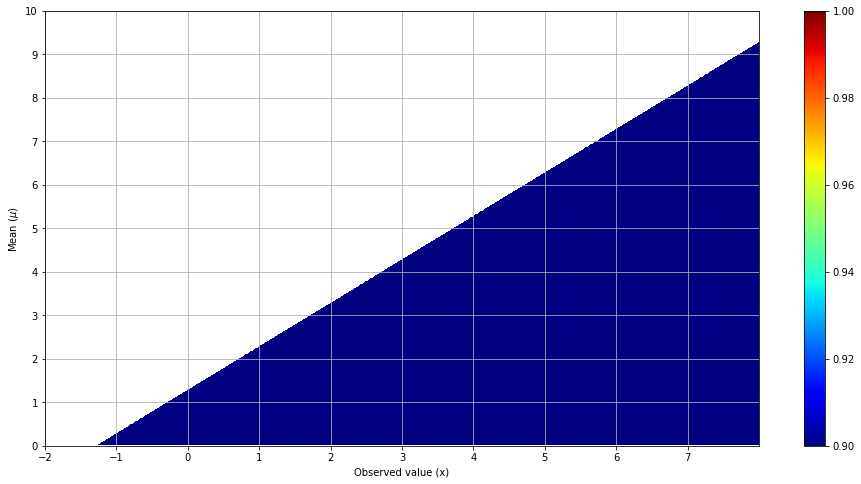

In [5]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp, norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

def get_upper_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(1-cl, mu, sig)
    return xm, 1.-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 10.
min_x = -2.
max_x = 8.
sigma = 1.
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm, p = get_upper_interval(cl, mean, sigma) # use funny function for mean and linearly increasing sigma
    xp = max_x
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(min_x,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/10. for x in range(11)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x))])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')

plt.colorbar(norms)
plt.show()


### 11.2 The issue of flip-flopping

#### Combining different approaches

As a remedy one might decide to combine these approaches, for example according to the following recipe:
- For a measured value above $3\sigma$ we quote a central interval.
- For a less significant value we quote an upper limit.
- For a negative measured value we quote a constant upper limit, the same as for $x_0=0$.

Do you think that this is a useful and statistically sound approach?

<a href="https://menti.com">menti.com</a> with key 94 83 82

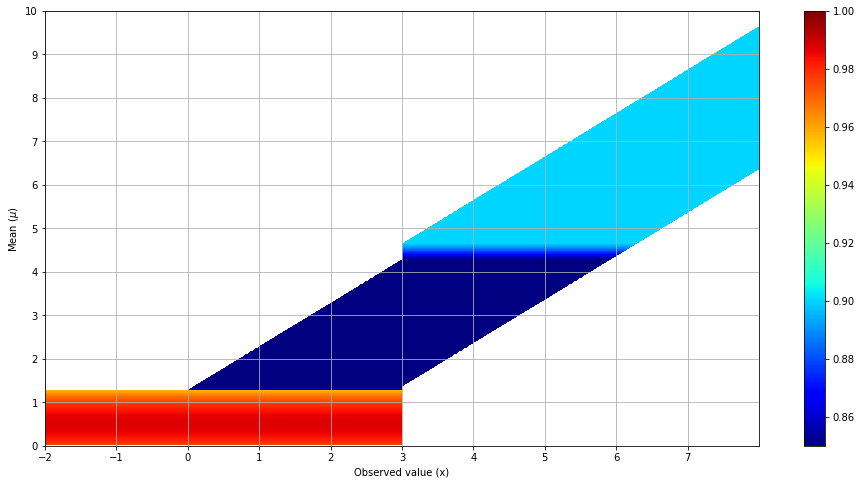

In [6]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp

def get_upper_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(1-cl, mu, sig)
    return xm

def get_prob(xm,xp,mu,sig):
    return norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 10.
min_x = -2.
max_x = 8.
sigma = 1.
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm_u = get_upper_interval(cl, mean, sigma) # x_minus for upper limit
    xm_c, xp_c = get_central_interval(cl, mean, sigma) # x_+/- for central interval
    if xm_c > 3:
        xm = xm_c
    elif xm_c <= 3 and xm_u > 3:
        xm = 3.
    elif xm_u > 0:
        xm = xm_u
    else:
        xm = min_x
    if xp_c > 3:
        xp = xp_c
    else:
        xp = 3.
    p = get_prob(xm,xp,mean,sigma)
    xp = min(xp, max_x)
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.85, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(min_x,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/10. for x in range(11)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x))])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')

plt.colorbar(norms)
plt.show()


#### Flip-flopping

You should have received sufficient warnings about fully defining your procedure prior to performing the measurement that this measurement-dependent recipe should set off some alarm bells.

Let's have a look at the coverage of this approach.

For $\mu=2$ the coverage is too low as the right-hand limit is defined by the central interval belt, which appears to be shifted up compared to the upper limit belt. Therefore, the intervals undercover, which is problematic.

Also, considering $\mu=1$, it is apparent that the intervals overcover. More generally, for $\mu$ between $0$ and about $1.2$ the coverage obviously varies as the interval stays constant while $P(x|\mu)$ changes.


#### Poisson belts

In the case of a counting experiment we have to use Poisson intervals, which have the particularity of leading to stair-like plots as they refer to a discrete distribution, i.e. we can only observe whole events.

In such experiments we are often interested in identifying a particular signal in the presence of background events.

The Poisson distribution function in the presence of a known amount of background, $b$, is

$$P(n|\mu)=e^{-(\mu+b)}\frac{(\mu+b)^n}{n!}.$$

As discussed before, when defining confidence intervals we rather overcover as we are in general unable to hit the desired confidence level exactly.

The following plots show the resulting confidence belts for central intervals and upper limits. They assume $b=3$.

The same issues apply as for the Gaussian case.

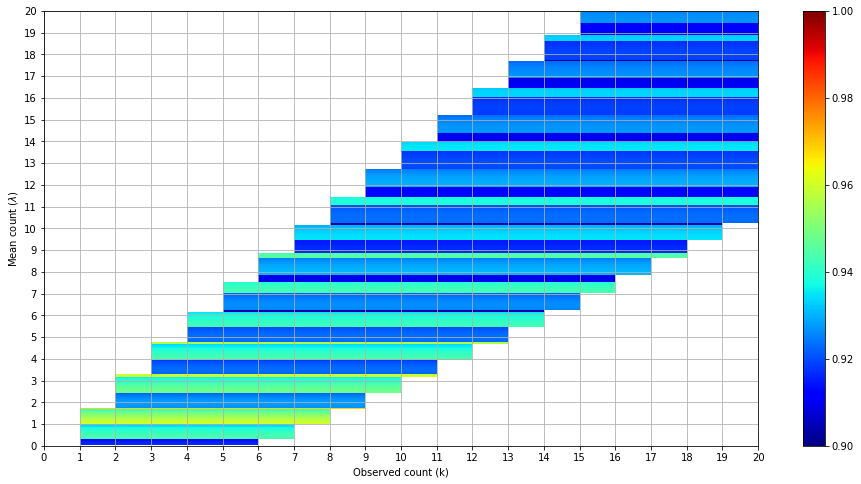

In [7]:
def get_central_interval(cl, l):
    # calculate r- and r+ based on pre-defined functions
    km = poisson.ppf(0.5*(1-cl)     , l)
    kp = poisson.ppf(0.5*(1-cl) + cl, l)
    if km > 0: 
        return km, kp, poisson.cdf(kp,l)-poisson.cdf(km-1,l)
    else:
        return km, kp, poisson.cdf(kp,l)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
poisson_patches = []
poisson_colors = []
max_mean = 20.
max_x = 20
background = 3
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    km, kp, p = get_central_interval(cl, mean+background) # use fast implementation
    poisson_patches.append( Rectangle((km,mean),kp-km,max_mean/nSamples) ) # define drawing object for confidence interval
    poisson_colors.append(p)
poissons = PatchCollection(poisson_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
poissons.set_array(np.array(poisson_colors))
poissons.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(poissons) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed count (k)')
ax.set_ylabel('Mean count ($\lambda$)')

plt.colorbar(poissons)
plt.show()


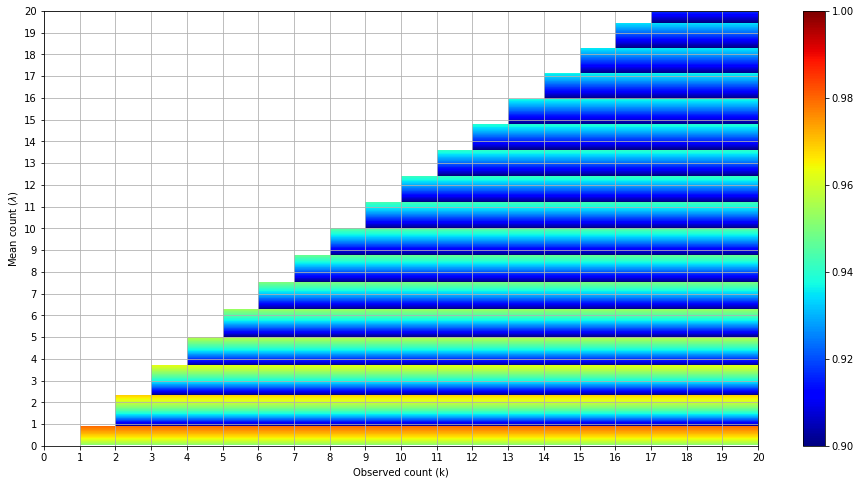

In [8]:
def get_upper_interval(cl, l):
    # calculate r- and r+ based on pre-defined functions
    km = poisson.ppf(1-cl, l)
    if km > 0: 
        return km, 1.-poisson.cdf(km-1,l)
    else:
        return km, 1.

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
poisson_patches = []
poisson_colors = []
max_mean = 20.
max_x = 20
background = 3
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    km, p = get_upper_interval(cl, mean+background) # use fast implementation
    kp = max_x
    poisson_patches.append( Rectangle((km,mean),kp-km,max_mean/nSamples) ) # define drawing object for confidence interval
    poisson_colors.append(p)
poissons = PatchCollection(poisson_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
poissons.set_array(np.array(poisson_colors))
poissons.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(poissons) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed count (k)')
ax.set_ylabel('Mean count ($\lambda$)')

plt.colorbar(poissons)
plt.show()


### 11.3 The Feldman-Cousins method

The issue of flip-flopping is caused by the mixture of vertical and horizontal construction of the confidence intervals. It is therefore desirable to have an approach that solely depends on a horizontal construction.

A purely horizontal construction cannot a priori define whether it results in an interval or an upper limit as this is, in the end, a result of a vertical cut through the confidence belt at the measured value.

Feldman and Cousins proposed the following alternative approach. The method may appear a little contrived, but this is simply due to the fact that it is strictly restricted to a horizontal construction that does not pre-define whether a central interval or an upper limit is being constructed. 

The following example is based on a counting experiment (therefore involving Poisson distributions) with the presence of background.
This means that the total count $n$ will include a certain number $b$ of background events, where $b$ is assumed to be known.

It proceeds as follows:
- Consider the construction of a confidence interval of level $\alpha$ for a given $\mu$.
- For each value of $n$ there is a value of $\mu$ that maximises $P(n|\mu)$ and this value shall be called $\mu_{\rm best}$.
- In our case this is simply $\mu_{\rm best}={\rm max}(0,n-b)$.
- Define the ratio $R=P(n|\mu)/P(n|\mu_{\rm best})$. Given that $\mu_{\rm best}$ maximises the probability distribution function, this ratio is between $0$ and $1$.
- Order all possible values of $n$ by their corresponding values of $R$ and, starting from the largest $R$, add the values of $n$ to the confidence interval until the sum of their probabilities exceeds $\alpha$.

The relevant values for an example with $b=3$ and $\mu=0.5$ are given in the table below.
The probabilities of rank 1-7 add up to (compare the column 'CumulativeSum')

$$0.189+0.216+0.185+0.132+0.106+0.030+0.077 = 0.935,$$

which covers a 90% interval.

This construction leads to an automatic transition between one-sided and two-sided intervals and thereby gives a pre-defined transition from quoting a two-sided interval to an upper limit. Note that nowhere in this procedure does the observed number of events enter.

There are two caveats around the Feldman-Cousins method:
- In the case of having observed 0 events, a measurement with greater levels of expected background can lead to a lower upper limit compared to a measurement with fewer expected background events.
- The approach does not readily allow the inclusion of so-called nuisance parameters, which are used to account for systematic uncertainties. However, alternatives exist that mitigate this issue.

The corresponding confidence belt looks as follows.

  1%|          | 2/399 [00:00<00:30, 12.85it/s]

Calculating P(n|mu_best)
Calculating intervals


  3%|▎         | 12/399 [00:00<00:27, 14.06it/s]

Table for mu =  0.5
       k       P(k|mu)  mu_best  P(k|mu_best)             R  CumulativeSum
4    4.0  1.888123e-01      1.0      0.195367  9.664501e-01       0.188812
3    3.0  2.157855e-01      0.0      0.224042  9.631482e-01       0.404598
2    2.0  1.849590e-01      0.0      0.224042  8.255556e-01       0.589557
5    5.0  1.321686e-01      2.0      0.175467  7.532375e-01       0.721725
1    1.0  1.056908e-01      0.0      0.149361  7.076191e-01       0.827416
0    0.0  3.019738e-02      0.0      0.049787  6.065307e-01       0.857614
6    6.0  7.709835e-02      3.0      0.160623  4.799953e-01       0.934712
7    7.0  3.854917e-02      4.0      0.149003  2.587145e-01       0.973261
8    8.0  1.686526e-02      5.0      0.139587  1.208230e-01       0.990126
9    9.0  6.558714e-03      6.0      0.131756  4.977938e-02       0.996685
10  10.0  2.295550e-03      7.0      0.125110  1.834825e-02       0.998981
11  11.0  7.304022e-04      8.0      0.119378  6.118396e-03       0.999711
12  1

100%|██████████| 399/399 [00:24<00:00, 16.10it/s]


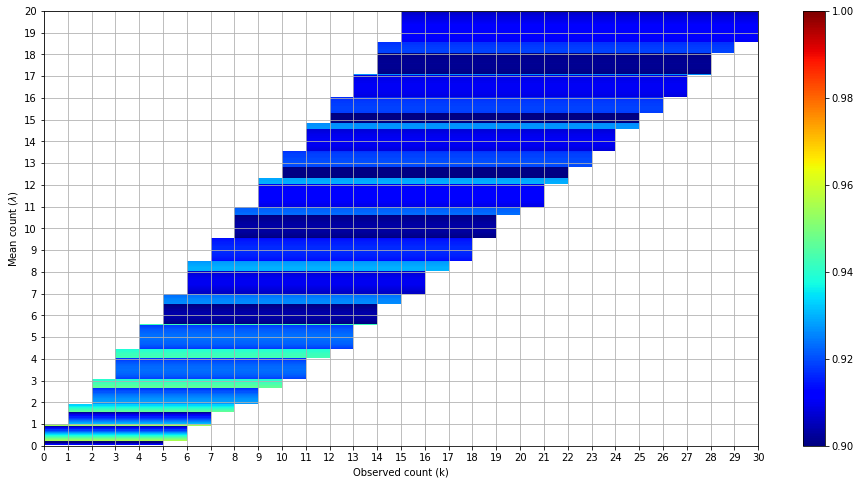

In [9]:
import pandas as pd

def get_prob(km,kp,l):
    if km > 0:
        return poisson.cdf(kp,l)-poisson.cdf(km-1,l)
    else:
        return poisson.cdf(kp,l)

cl = 0.9
nSamples = 400 # defines granularity in y, takes about 0.05s per sample
poisson_patches = []
poisson_colors = []
max_mean = 20.
max_x = 30
background = 3

print('Calculating P(n|mu_best)')
p_mubest = []
for k in range(max_x+1):
    mubest = max(0,k-background)
    p_mubest.append(poisson.pmf(k,mubest+background))

print('Calculating intervals')
for i in trange(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    FC_table = pd.DataFrame(columns=['k','P(k|mu)','mu_best','P(k|mu_best)'])
    for k in range(max_x+1):
            mubest = max(0,k-background)
            p_this = poisson.pmf(k,mean+background)
            p_best = p_mubest[k]
            #print(mean,k,mubest,p_best,p_this)
            if 0 < p_best:
                FC_table = FC_table.append({'k':k,'P(k|mu)':p_this,'mu_best':mubest,'P(k|mu_best)':p_best}, ignore_index=True)
    FC_table['R'] = FC_table['P(k|mu)'] / FC_table['P(k|mu_best)']
    FC_table = FC_table.sort_values('R',ascending = False)
    FC_table['CumulativeSum'] = FC_table['P(k|mu)'].cumsum()
    if 10 == i: 
        print('Table for mu = ',mean)
        print(FC_table)
    good_ks = FC_table.query('CumulativeSum < @cl')['k'].values
    good_ks = np.hstack([good_ks, FC_table.query('CumulativeSum >= @cl').head(1)['k'].values])
    #print(good_ks)
    km = good_ks.min()
    kp = good_ks.max()
    p = get_prob(km, kp, mean+background)
    kp = min(kp,max_x)
    poisson_patches.append( Rectangle((km,mean),kp-km,max_mean/nSamples) ) # define drawing object for confidence interval
    poisson_colors.append(p)
poissons = PatchCollection(poisson_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
poissons.set_array(np.array(poisson_colors))
poissons.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(poissons) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed count (k)')
ax.set_ylabel('Mean count ($\lambda$)')

plt.colorbar(poissons)
plt.show()


#### Continuous case

For a Gaussian (i.e. continuous) variable the procedure is very similar. In short, it is:

- For a Gaussian distributed variable $\mu$ with boundary condition $\mu\ge0$, find the value of $\mu$ for which $P(x|\mu)$ is maximal and call this $\mu_{\rm best}$. This is given by $\mu_{\rm best}={\rm max}(0,x)$.

- Define the likelihood ratio

$$R(x)=\frac{P(x|\mu)}{P(x|\mu_{\rm best})}.$$

- For a given $\mu$ find the interval $[x_1,x_2]$ such that $R(x_1)=R(x_2)$ and $\int_{x_1}^{x_2}P(x|\mu)dx=\alpha$, with $\alpha$ the desired confidence level. This integral gives the accepted range for each value of $\mu$.

The condition $R(x_1)=R(x_2)$ replaces the explicit ordering and, provided that $R(x)$ is continuously falling on either side of $x=\mu_{\rm best}$, it uniquely defines the interval $[x_1,x_2]$ for a given $\alpha$.

At $x=1.28$ the distribution transitions from a one-sided to a two-sided interval.

The full confidence belt is shown in the following plot.

#### Computation requirements

The continuous case requires calculating and sorting many values in $x$ for each value in $\mu$. The exact number is defined by the desired resolution of the plot. 

The plot below already takes several minutes to compute while it is based on a simple Gaussian function. However, here we knew the correct values for $\mu_{\rm best}$ a priori.

If $\mu_{\rm best}$ needs to be calculated, this can add considerable computation requirements.

In reality, this method is likely to be applied to much more complex probability densitiy functions, which take significantly longer to evaluate. Therefore, it can be computationally challenging to obtain a result with the Feldman-Cousins method.

  0%|          | 0/399 [00:00<?, ?it/s]

Calculating P(n|mu_best)
Calculating intervals


  1%|▏         | 5/399 [00:03<03:55,  1.67it/s]

Table for mu =  0.075
         x       P(x|mu)  mu_best  P(x|mu_best)             R  CumulativeSum
83   0.075  3.989423e-01    0.075      0.398942  1.000000e+00       0.009974
82   0.050  3.988176e-01    0.050      0.398942  9.996875e-01       0.019944
84   0.100  3.988176e-01    0.100      0.398942  9.996875e-01       0.029914
81   0.025  3.984439e-01    0.025      0.398942  9.987508e-01       0.039876
85   0.125  3.984439e-01    0.125      0.398942  9.987508e-01       0.049837
80   0.000  3.978218e-01    0.000      0.398942  9.971915e-01       0.059782
86   0.150  3.978218e-01    0.150      0.398942  9.971915e-01       0.069728
79  -0.025  3.969525e-01    0.000      0.398818  9.953235e-01       0.079652
87   0.175  3.969525e-01    0.175      0.398942  9.950125e-01       0.089575
78  -0.050  3.958377e-01    0.000      0.398444  9.934590e-01       0.099471
88   0.200  3.958377e-01    0.200      0.398942  9.922179e-01       0.109367
77  -0.075  3.944793e-01    0.000      0.397822  9.915

100%|██████████| 399/399 [04:10<00:00,  1.59it/s]


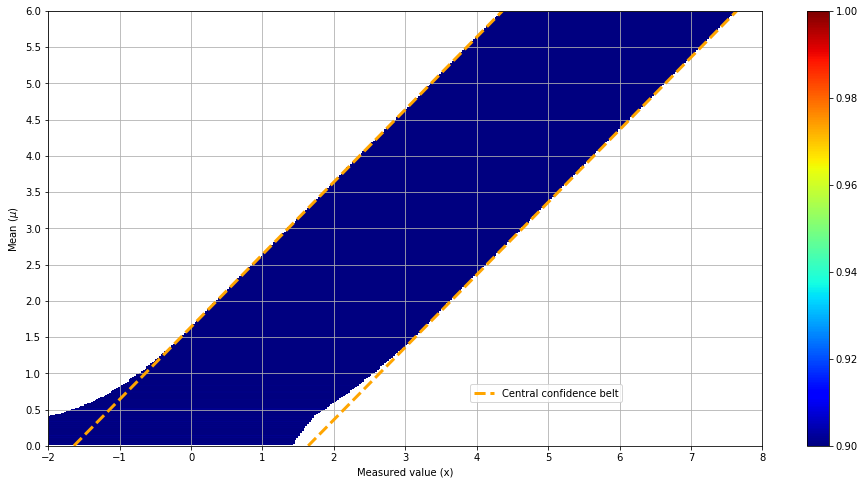

In [10]:
def get_prob(xm,xp,mu,sigma):
    return norm.cdf(xp,mu,sigma)-norm.cdf(xm,mu,sigma)

cl = 0.9
nSamples = 400 # defines granularity in x and y, takes about 0.5s per sample
norm_patches = []
norm_colors = []
max_mean = 6.
min_x = -2.
max_x = 8.
sigma = 1.
binw = (max_x - min_x) / nSamples

print('Calculating P(n|mu_best)')
p_mubest = []
for i in range(nSamples):
    x = min_x + i / nSamples * (max_x - min_x)
    mubest = max(0, x)
    p_mubest.append(norm.pdf(x,mubest,sigma))

print('Calculating intervals')
for i in trange(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    FC_table = pd.DataFrame(columns=['x','P(x|mu)','mu_best','P(x|mu_best)'])
    for j in range(nSamples):
        x = min_x + j / nSamples * (max_x - min_x)
        mubest = max(0, x)
        p_this = norm.pdf(x,mean,sigma)
        p_best = p_mubest[j]
        if 0 < p_best:
            FC_table = FC_table.append({'x':x,'P(x|mu)':p_this,'mu_best':mubest,'P(x|mu_best)':p_best}, ignore_index=True)
    FC_table['R'] = FC_table['P(x|mu)'] / FC_table['P(x|mu_best)']
    FC_table = FC_table.sort_values('R',ascending = False)
    FC_table['CumulativeSum'] = FC_table['P(x|mu)'].cumsum()*binw
    if 5 == i: 
        print('Table for mu = ',mean)
        print(FC_table)
    good_xs = FC_table.query('CumulativeSum < @cl')['x'].values
    good_xs = np.hstack([good_xs, FC_table.query('CumulativeSum >= @cl').head(1)['x'].values])
    xm = good_xs.min()
    xp = good_xs.max()
    p = get_prob(xm, xp, mean,sigma)
    xm = max(xm,min_x)
    xp = min(xp,max_x)
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/12. for x in range(13)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x)+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Measured value (x)')
ax.set_ylabel('Mean ($\mu$)')

ax.plot([-1.64,max_mean-1.64],[0,max_mean],color='orange',linewidth=3,linestyle='--',label='Central confidence belt')
ax.plot([1.64,max_mean+1.64],[0,max_mean],color='orange',linewidth=3,linestyle='--')
ax.legend(loc=[0.59,0.10])

plt.colorbar(norms)
plt.show()


### 11.4 The CLs method

The $CL_s$ method is another limit-setting method commonly used in high-energy physics. It has some coverage issues that will be discussed later, which is why it is disliked by some purists, but it has other practical advantages over stricter methods such as Feldman-Cousins.

The method is based on comparing two hypotheses. The null hypothesis is that an observation is based on background only, while the alternative hypothesis is that an observation is due to a combination of background and signal.

One defines the two probabilities, the first

$$p_{s+b}=P(x\le x_{\rm obs}|{s+b})=\int_{-\infty}^{x_{\rm obs}} f(x|{s+b})dx,$$

which represents the probability for observing an $x$ that is more background-like than $x_{\rm obs}$. For a counting experiment this corresponds to $x\le x_{\rm obs}$. The value of $p_{s+b}$ depends on the amount of signal assumed in the hypothesis.

The second probability is

$$p_{b}=P(x\ge x_{\rm obs}|{b})=\int_{x_{\rm obs}}^{\infty} f(x|{b})dx,$$

which represents the probability of a pure background sample giving a value of $x$ that is more signal-like than $x_{\rm obs}$.

The following gives an illustration of the situation.

Working with nB = 4 , nS = 1 , and an observed count of 4
p_(s+b)=0.4405
p_b=0.3712
p_(s+b)/(1-p_b)=0.7005


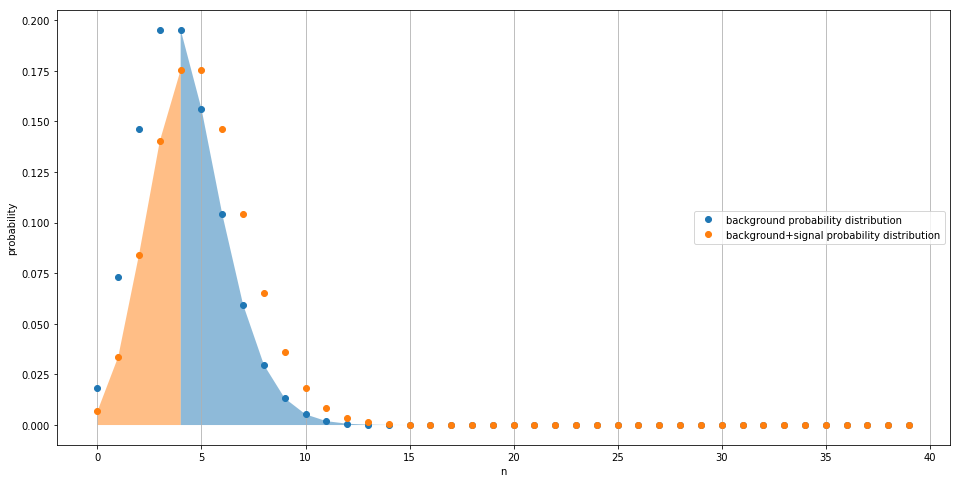

In [17]:
nB = 1500      # background counts
nS = 250         # signal counts <-- vary this and scan CLs
xObs = 1600    # observed counts
xMin = 1350
xMax = 1750
nB = 4        # background counts
nS = 1         # signal counts
xObs = 4
xMin = 0
xMax = 40
print('Working with nB =', nB, ', nS =', nS, ', and an observed count of', xObs)

x = range(xMin,xMax)     # plotting range
rvB = poisson(nB)        # initialise Poisson distribution
probsB = rvB.pmf(x)      # calculate Poisson probabilities for all values of x and return list
rvS = poisson(nB+nS)     # initialise Poisson distribution
probsS = rvS.pmf(x)      # calculate Poisson probabilities for all values of x and return list

xB = range(xObs,xMax)
xSB = range(xMin,xObs+1)

probsSBi = rvS.pmf(xSB)
probsBi = rvB.pmf(xB)

pSB = rvS.cdf(xObs)
pB = 1.-rvB.cdf(xObs)
print('p_(s+b)={0:.4}'.format(pSB))
print('p_b={0:.4}'.format(pB))
print('p_(s+b)/(1-p_b)={0:.4}'.format(pSB/(1.-pB)))

# prepare plot
fig,ax1 = plt.subplots(figsize=(16, 8))

# plot the probability distribution
ax1.plot(x,probsB, "o", label='background probability distribution')
ax1.plot(x,probsS, "o", label='background+signal probability distribution')
ax1.fill_between(xB,0,probsBi, alpha=0.5)
ax1.fill_between(xSB,0,probsSBi, alpha=0.5)

# plot optics
ax1.grid(which='both',axis='x')
ax1.set_xlabel('n')
ax1.set_ylabel('probability')

h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc=5)

plt.show()

The 90.0% CL limit is 12


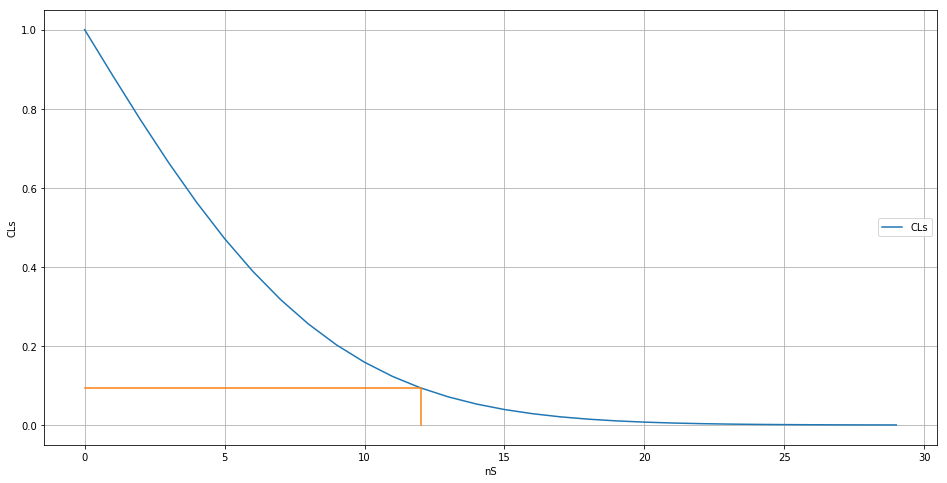

In [20]:
cl = 0.9

nB = 1500      # background counts
xObs = 1600    # observed counts
nB = 40        # background counts
xObs = 40

rvB = poisson(nB)        # initialise Poisson distribution
pB = 1.-rvB.cdf(xObs)

xs = []
ys = []
for nS in range(0,30):
  rvS = poisson(nB+nS)     # initialise Poisson distribution
  pSB = rvS.cdf(xObs)
  clS = pSB/(1.-pB)
  xs.append(nS)
  ys.append(clS)

limit = 1. - cl
xClose = xs[0]
yClose = ys[0]
for x,y in zip(xs,ys):
    if abs(yClose-limit) > abs(y-limit):
        yClose = y
        xClose = x
print('The {0:}% CL limit is {1:}'.format(100*cl,xClose))

# prepare plot
fig,ax1 = plt.subplots(figsize=(16, 8))

# plot the probability distribution
ax1.plot(xs,ys, label='CLs')
ax1.plot([0,xClose,xClose],[yClose,yClose,0])

# plot optics
ax1.grid(which='both',axis='both')
ax1.set_xlabel('nS')
ax1.set_ylabel('CLs')

h1, l1 = ax1.get_legend_handles_labels()
ax1.legend(h1, l1, loc=5)

plt.show()

#### Limit setting

We discussed confidence leves in weeks 7 and 8. These were mostly discussed in scenarios not affected by limitations of the parameters that are being assessed. In this part we cover the somewhat more complicated situation 

Considering for a moment only the first probability, for a small signal compared to the amount of background (as illustrated here) and a very small observed value, i.e. a downward fluctuation in the background, leads to a limit with low significance. In the example above an observation of 1400 counts leads to a p-value of $0.4\%$.

However, there is $99.5\%$ of the background-only spectrum that looks more signal-like than the observed value of 1400 counts.

The $CL_s$ method modifies the initial p-value and defines

$$CL_s\equiv\frac{p_{s+b}}{1-p_b}.$$

This fraction effectively introduces a penalty term for the case that both hypotheses have very similar probability distribution functions, which is equivalent with saying that the measurement has little sensitivity. We already discussed exactly this aspect when covering hypothesis testing. 

In our example, $CL_s$ now becomes $\frac{0.4\%}{1-99.5\%}=\frac{0.4\%}{0.5\%}=80\%$, so we would not be able to set any stringent limit due to the lack of sensitivity.

In the extreme case of a measured count of zero, i.e. neither signal nor background lead to a measurement, $CL_s$ is always $100\%$, which  then prevents the setting of a $90\%$ upper limit. While this is considered a mathematical drawback by some, it actually represents a meaningful safety mechanism against setting unjustified limits.

If the two hypotheses have very well separated distributions, a signal-like observation carries practically no penalty term.

#### Example: how many students in this course have already a university degree?

<a href="https://menti.com">menti.com</a> with key 55 63 86.

#### $CL_s$ in practice

When applying the $CL_s$ method in practice one would want to establish the sensitivity of a method beforehand. Therefore, one would calculate the $CL_s$ values for a range of conceivable amounts of signal and for the expected level of background.

As the amount of background will fluctuate according to Poisson statistics, what is commonly done is to simulate an ensemble of background sets and calculate the $CL_s$ value for each of them. Then, one plots the median $CL_s$ value for every considered signal value alongside the spread of the ensemble.

Finally, once the number of observed counts have been determined, one can draw a curve of observed limits with the actual signal and background numbers. The ensemble of expected limits now serves as a control check against statistical fluctuations.

The single value to be quoted as the observed limit depends on the desired confidence level.

Here is an example of a recent publication by our group. Reference: <a href="https://doi.org/10.1016/j.physletb.2016.01.029">R. Aaij et al. (LHCb collaboration), Phys. Lett. B754 (2016) 167</a>. The limit is set at the $90\%$ confidence level (hence the line at $CL_s=0.10$) and the observed limit is below the median expected limit due to a downward fluctuation in the observed background.

<img src="images/hidef_Fig4.png" width=60%>

<div class="well" align="center">
    <div class="container-fluid">
        <div class="row">
            <div class="col-md-3" align="center">
                <img align="center" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" width="60%">
            </div>
            <div class="col-md-8">
            This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>).
            </div>
        </div>
    </div>
    <br>
    <br>
    <i>Note: The content of this Jupyter Notebook is provided for educational purposes only.</i>
</div>